# Systematic analysis of biases applied on NFB ADHD

This method takes advantage of studies technical and methodological high heterogeneity rather than suffering from it. Indeed, the domain of Neurofeedback (NFB) applied to ADHD children is characterized by a clinical litterature that is tremendously heterogeneous. Since we supposed that the methodologcial and technical choices made by authors may impact the efficay of NFB, we propose here to identify which of the factors independently influence the reported within-subject effect size (ES) thanks to adequate statistical tools (weighted least squares, regularization LASSO and a decision tree). See *Bussalb et al*.

## Import raw data

If you have not installed the ```source_assess_treatment_efficacy``` package (see ```README.md```) do not forget to uncomment and change the path given in ```sys.path.append```. It corresponds to the path where the modules are. Besides, make sure the requirements noted in ```requirements.txt``` are fulfilled. The csv file containing all required information (*values_total_meta_analysis_all_factors.csv*) is available. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import random
import sys

from IPython.display import display

# Add the path where the packages are
# sys.path.append(r"C:\Users\Aurore Bussalb\meta-analysis-statistical-tools")
import source_assess_treatment_efficacy.systematic_analysis_of_biases.import_csv_for_factors as icf
import source_assess_treatment_efficacy.systematic_analysis_of_biases.perform_saob as saob

%matplotlib inline

# Import data from a csv file
df_parents, df_teachers, df_clinicians = icf.import_csv('values_total_meta_analysis_all_factors.csv')
df = pd.concat([df_parents, df_teachers, df_clinicians])

# Test if there are clinician scores
if df_clinicians.empty == True: 
    df = pd.concat([df_parents, df_teachers])
else:
    df = pd.concat([df_parents, df_teachers, df_clinicians])

## Compute the within effect size

We compute the within subject effect size (Cohen, 1988) for each clinical scale available in the articles included in the analysis. 

In [2]:
# Cohen J. (1988). Statistical Power Analysis for the Behavioral Sciences
df['effect_size_treatment'] = df[['mean_post_test_treatment','mean_pre_test_treatment',
                                  'std_post_test_treatment','std_pre_test_treatment']
                                ].apply(lambda row:saob.effect_size_within_subjects(**row), axis=1) 

## Preprocess factors 

The pre-processing of factors for the analysis includes the following steps: factors for which there are too many missing observations, arbitrarily set to more than 20% of the total of observations, are removed from the analysis. Furthermore, if a factor has more than 80% similar observations it is removed as well. Categorical variables are coded as dummies meaning that the presence of the factor is represented by a 1 and its absence by 0. All variables are standardized, except when the decision tree is performed.

In [3]:
X, X_non_standardized = saob.preprocess_factors(df)

The type of thresholding, the use of a transfer card, the protocol beta up in frontal areas, the EEG quality equal to 3 and the presence of a control group are removed from the analysis.

C:\Users\Aurore Bussalb\Programing\Anaconda3\envs\treatment-efficacy-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of the within ES across studies')

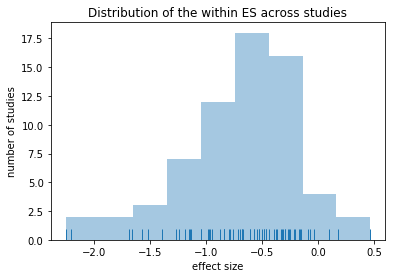

In [4]:
# Detect outliers
plt.figure()  
sns.distplot(df['effect_size_treatment'].values, kde=False, rug=True)
plt.xlabel('effect size')
plt.ylabel('number of studies')  
plt.title('Distribution of the within ES across studies')  

No outlier has been detected.

<Figure size 432x288 with 0 Axes>

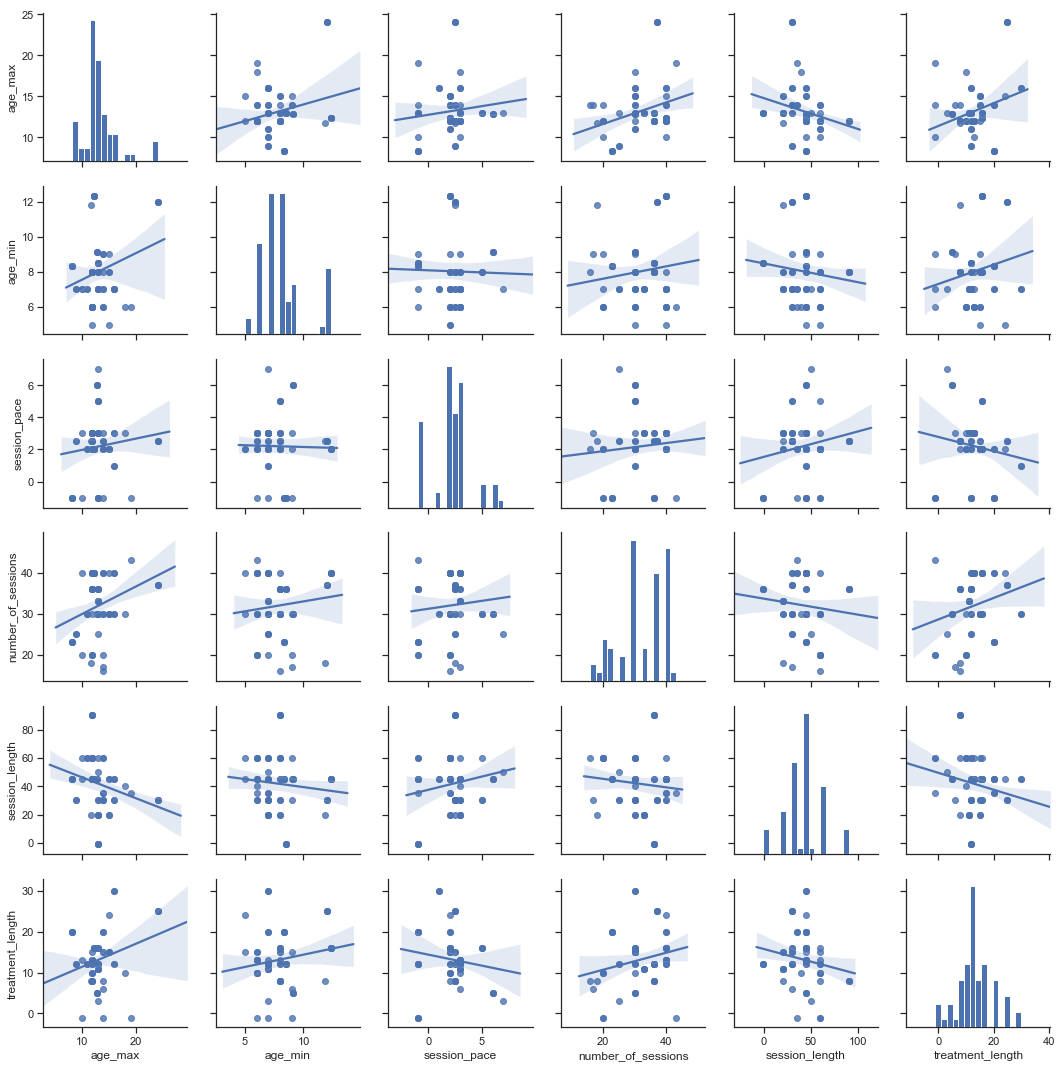

In [5]:
# Correlation plot between continuous variables
X_continuous_variables = X_non_standardized[['age_max', 'age_min', 
                                             'session_pace', 'number_of_sessions', 
                                             'session_length', 'treatment_length']] 
plt.figure()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(X_continuous_variables, kind = "reg", diag_kws=dict(bins=15))   

Continuous variables seem not correlated.

Text(0, 0.5, 'standardized values')

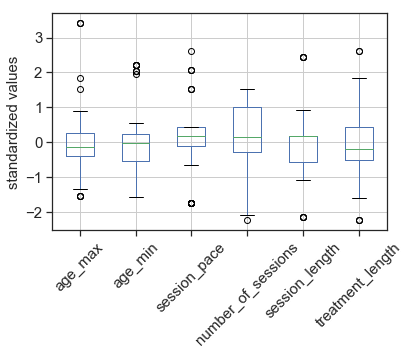

In [6]:
# Boxplots to assess the spread of the factors 
plt.figure()
ax = X.boxplot(['age_max', 'age_min', 'session_pace', 'number_of_sessions', 'session_length',
                'treatment_length'], fontsize=15, rot=45)
ax.set_ylabel('standardized values', fontsize=15)

Number of sessions, session and treatment length are more variable across studies than the age of included children and session space. 

In order to prevent any bias, it is possible to hide factor names during the analysis: 

In [7]:
# Run this cell to hide variable names
X.columns = random.sample(range(1, len(X.columns)+1), len(X.columns))
X_non_standardized.columns = X.columns

## First method: Weighted Least Squares (WLS)

The aim of the WLS is to estimate the regression coefficients of a **linear** and **weighted** model. A significant coefficient (meaning significantly different from 0) indicates that the associated factor has probably an influence on NFB efficacy and the sign of the coefficient indicates the direction of the effect. 

In [8]:
# WLS
summary = saob.weighted_linear_regression(df, X, df['effect_size_treatment'])
display(summary)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                              WLS Regression Results                             
=================================================================================
Dep. Variable:     effect_size_treatment   R-squared:                       0.737
Model:                               WLS   Adj. R-squared:                  0.628
Method:                    Least Squares   F-statistic:                     6.775
Date:                   Wed, 07 Nov 2018   Prob (F-statistic):           5.97e-08
Time:                           18:12:52   Log-Likelihood:                -24.252
No. Observations:                     66   AIC:                             88.50
Df Residuals:                         46   BIC:                             132.3
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -0.6486      0.053    -12.246      0.000      -0.755      -0.542
number_of_sessions                            -0.1411      0.080     -1.759      0.085      -0.303       0.020
age_min                                        0.0415      0.068      0.615      0.541      -0.094       0.177
age_max                                       -0.0300      0.072     -0.419      0.677      -0.174       0.114
session_pace                                  -0.2061      0.068     -3.052      0.004      -0.342      -0.070
session_length                                -0.1194      0.129     -0.927      0.359      -0.379       0.140
treatment_length                               0.5030      0.089      5.654      0.000       0.324       0.682
EEG_quality_two                               -0.3509      0.085     -4.114      0.000      -0.523      -0.179
theta_down_yes                                -0.1839      0.134     -1.372      0.177      -0.454       0.086
artifact_correction_based_on_amplitude_yes     0.0031      0.079      0.040      0.968      -0.155       0.162
on_drugs_yes                                  -0.1498      0.087     -1.714      0.093      -0.326       0.026
SCP_yes                                       -0.0268      0.172     -0.156      0.877      -0.373       0.319
SMR_yes                                        0.0107      0.089      0.120      0.905      -0.169       0.190
EOG_correction_yes                            -0.1551      0.115     -1.345      0.185      -0.387       0.077
beta_up_central_yes                            0.0311      0.088      0.351      0.727      -0.147       0.209
transfer_phase_yes                             0.5285      0.136      3.893      0.000       0.255       0.802
randomization_yes                              0.1275      0.078      1.640      0.108      -0.029       0.284
pblind_yes                                     0.1288      0.057      2.254      0.029       0.014       0.244
IRB_yes                                       -0.2918      0.086     -3.384      0.001      -0.465      -0.118
more_than_one_active_electrode_yes            -0.0451      0.078     -0.579      0.565      -0.202       0.112
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.104
Skew:                           0.218   Prob(JB):                        0.349
Kurtosis:                       2.242   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard

We can rely on the WLS results, because the following assumptions are satisfied:
* The moment matrix is invertible, 
* There is no apparent correltion between the continuous independent variables,
* The fit is significant: ```prob(F-statistic) = 5.97e-08```,
* The residuals are normally distributed: ```skew = 0.218```, ```kurtosis = 2.242``` and the Omnibus test ```(prob(Omnibus) = 0.188)```. 

In order to assess the impact of the weights on the results, we compare the WLS results with those obtained with the Ordinary Least Squares (OLS).

In [9]:
# Run the OLS to compare results
summary_ols = saob.ordinary_linear_regression(X, df['effect_size_treatment'])
display(summary_ols)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     effect_size_treatment   R-squared:                       0.526
Model:                               OLS   Adj. R-squared:                  0.331
Method:                    Least Squares   F-statistic:                     2.689
Date:                   Wed, 07 Nov 2018   Prob (F-statistic):            0.00316
Time:                           18:12:53   Log-Likelihood:                -26.029
No. Observations:                     66   AIC:                             92.06
Df Residuals:                         46   BIC:                             135.9
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -0.6865      0.053    -12.971      0.000      -0.793      -0.580
number_of_sessions                            -0.0889      0.089     -1.000      0.323      -0.268       0.090
age_min                                        0.0494      0.080      0.619      0.539      -0.111       0.210
age_max                                        0.0427      0.090      0.475      0.637      -0.138       0.223
session_pace                                  -0.1176      0.074     -1.599      0.117      -0.266       0.030
session_length                                -0.0754      0.140     -0.538      0.593      -0.357       0.207
treatment_length                               0.3788      0.104      3.635      0.001       0.169       0.589
EEG_quality_two                               -0.2527      0.097     -2.617      0.012      -0.447      -0.058
theta_down_yes                                -0.1014      0.149     -0.681      0.500      -0.401       0.198
artifact_correction_based_on_amplitude_yes    -0.0532      0.081     -0.659      0.513      -0.216       0.109
on_drugs_yes                                  -0.1291      0.105     -1.231      0.224      -0.340       0.082
SCP_yes                                        0.0146      0.193      0.076      0.940      -0.373       0.402
SMR_yes                                        0.0506      0.098      0.519      0.606      -0.146       0.247
EOG_correction_yes                            -0.0610      0.134     -0.456      0.650      -0.330       0.208
beta_up_central_yes                            0.0291      0.101      0.288      0.775      -0.174       0.232
transfer_phase_yes                             0.4013      0.161      2.492      0.016       0.077       0.725
randomization_yes                              0.1411      0.092      1.542      0.130      -0.043       0.325
pblind_yes                                     0.1425      0.058      2.455      0.018       0.026       0.259
IRB_yes                                       -0.2225      0.098     -2.260      0.029      -0.421      -0.024
more_than_one_active_electrode_yes            -0.0114      0.089     -0.129      0.898      -0.190       0.167
==============================================================================
Omnibus:                        0.574   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.136
Skew:                          -0.001   Prob(JB):                        0.934
Kurtosis:                       3.222   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard

Here again, the assumptions are satisfied.
Less factors are found significantly different from 0 with OLS.

## Second method: Least Absolute Shrinkage and Selection Operator (LASSO)

The second method is **linear** and incorporates **variable selection** in the linear model. A coefficient not set to zero must explain the model (so it may have an influence of NFB efficacy). The sign of the coefficient indicates the direction of the effect.

In [10]:
coeff, mse_test, alphas, alpha = saob.regularization_lassocv(X, df['effect_size_treatment'])
print('Tuning parameter found by CV', alpha)
display(coeff)  

Tuning parameter found by CV 0.02643034162589421


,Factors,Coefficients
0,number_of_sessions,-0.000000
1,age_min,0.000000
2,age_max,0.000000
3,session_pace,-0.051277
4,session_length,-0.000000
5,treatment_length,0.190396
6,EEG_quality_two,-0.102121
7,theta_down_yes,-0.000000
8,artifact_correction_based_on_amplitude_yes,-0.000000
9,on_drugs_yes,0.000000


Text(0.5, 1.0, 'Mean square error on the folds and the mean fold')

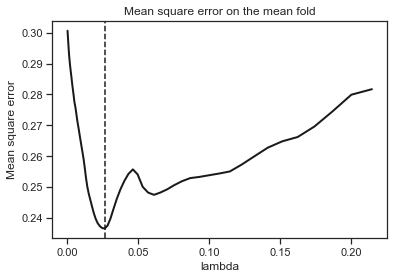

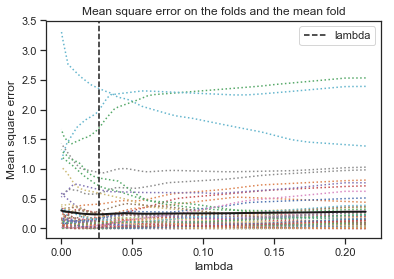

In [11]:
# Display results: see the better lambda
    
# MSE only on the mean fold
plt.figure()
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k', label='lambda')
plt.axvline(alpha, linestyle='--', color='k', label='alpha: CV estimate')
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the mean fold')
        
# MSE only on all the folds
plt.figure()
plt.plot(alphas, mse_test, ':')
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k')
plt.axvline(alpha, linestyle='--', color='k', label='lambda')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the folds and the mean fold')

Leave-one-out cross validation is applied to find the tuning parameter. The Mean Square Error (MSE) is computed on each test set. The tuning parameter correponds to the abscissa of the minimum value of the MSE on the mean fold. 

In [12]:
# Lasso with AIC criterion to compare results obtained with CV
coeff_aic = saob.regularization_lassoAIC(X, df['effect_size_treatment'])
display('Lasso results with AIC', coeff_aic) 

'Lasso results with AIC'

,Factors,Coefficients
0,number_of_sessions,0.000000
1,age_min,0.000000
2,age_max,0.000000
3,session_pace,-0.052579
4,session_length,0.000000
5,treatment_length,0.192814
6,EEG_quality_two,-0.103737
7,theta_down_yes,0.000000
8,artifact_correction_based_on_amplitude_yes,0.000000
9,on_drugs_yes,0.000000


When we determine the tuning parameter with the AIC criterion, the same factors as those obtained with the cross validation method are set to 0.

## Third method: Decision Tree

The last method used is the decision tree: a **hierarchical** and **non-linear** method.

In [13]:
# Decision tree
saob.decision_tree(X_non_standardized, df['effect_size_treatment'])

R² decision tree 0.4294642791479961
